# Predicting Duration Ride - NY Taxi Data (Jan and Feb)

In [1]:
# Import libraries
import pandas as pd
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from datetime import datetime
from lightgbm import LGBMRegressor 
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

In [2]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('ny_taxi_ride_duration')

2024/05/15 09:28:52 INFO mlflow.tracking.fluent: Experiment with name 'ny_taxi_ride_duration' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/mvoss/default_modeling_script/mlruns/1', creation_time=1715758132787, experiment_id='1', last_update_time=1715758132787, lifecycle_stage='active', name='ny_taxi_ride_duration', tags={}>

## Read in Data

In [3]:
# Get data
df_rides_jan = pd.read_parquet('data/yellow_tripdata_2024-01.parquet')
df_rides_feb = pd.read_parquet('data/yellow_tripdata_2024-02.parquet')

In [4]:
# Inspect data
df_rides_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
# Combine the data
df_rides = pd.concat([df_rides_jan, df_rides_feb], axis=0)

# Check the shape
df_rides.shape

(5972150, 19)

In [6]:
# Check data types
df_rides.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [7]:
# Check for NAs by column
df_rides.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          325772
trip_distance                 0
RatecodeID               325772
store_and_fwd_flag       325772
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     325772
Airport_fee              325772
dtype: int64

## Preprocessing

In [8]:
# Drop NA rows
df_rides = df_rides[~df_rides['passenger_count'].isna()]

In [9]:
# Drop certain variable not needed for modeling
df_rides = df_rides.drop(columns=['store_and_fwd_flag', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'])

In [10]:
# Create pick up time variables
df_rides['hour_of_day'] = df_rides['tpep_pickup_datetime'].dt.hour
df_rides['day_of_week'] = df_rides['tpep_pickup_datetime'].dt.dayofweek
df_rides['month_of_year'] = df_rides['tpep_pickup_datetime'].dt.dayofweek

In [11]:
# Prepare outcome variable
df_rides['ride_duration'] = df_rides['tpep_dropoff_datetime'] - df_rides['tpep_pickup_datetime']

# Convert to unix duration
df_rides['ride_duration'] = df_rides['ride_duration'].dt.total_seconds().astype(int)

# Transform outcome variable
df_rides = df_rides[(df_rides['ride_duration'] > 0) & (df_rides['ride_duration'] < 10000)]
df_rides['ride_duration'] = df_rides['ride_duration'] / 60

In [12]:
# Drop timestamps
df_rides = df_rides.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [13]:
# Check columns
df_rides.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'tip_amount', 'tolls_amount', 'total_amount', 'Airport_fee',
       'hour_of_day', 'day_of_week', 'month_of_year', 'ride_duration'],
      dtype='object')

In [14]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(df_rides.drop(columns=['ride_duration']), df_rides['ride_duration'], test_size=0.2, random_state=42)

In [15]:
# Define Preprocessing Steps
categorical_features = ['RatecodeID', 'payment_type', 'day_of_week', 'month_of_year', 'hour_of_day', 'PULocationID', 'DOLocationID',]

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="passthrough" 
)

# Build the Pipeline:
steps = [
    ("preprocessor", preprocessor),
    ("lgbm", LGBMRegressor(objective='regression', random_state=42, force_col_wise=True)),
]
pipeline = Pipeline(steps)

# Hyperparameter Tuning (Optional):
# parameters = { 
#     'lgbm__boosting_type': ['gbdt'],
#     'lgbm__num_leaves': [10, 20, 30],
#     'lgbm__max_depth': [-1, 10, 20],
#     'lgbm__learning_rate': [0.01, 0.001, 0.0001],
#     'lgbm__n_estimators': [200, 300, 400],
# }

## Modeling

In [16]:
# Set up the grid search object (Optional - in combination with hyperparameters)
# grid_search = GridSearchCV(pipeline, parameters, cv=2, verbose=1, n_jobs=None, scoring='r2')

In [17]:
# Fit to the training data
# grid_search.fit(X_train, y_train)
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 4512680, number of used features: 551
[LightGBM] [Info] Start training from score 14.963617


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['RatecodeID', 'payment_type',
                                                   'day_of_week',
                                                   'month_of_year',
                                                   'hour_of_day',
                                                   'PULocationID',
                                                   'DOLocationID'])])),
                ('lgbm',
                 LGBMRegressor(force_col_wise=True, objective='regression',
                               random_state=42))])

In [18]:
# Get the best parameters from the grid search
# best_params = grid_search.best_params_
# print(best_params)

## Testing

In [19]:
# Get the best parameters from the grid search
# best_model_prelim = grid_search.best_estimator_

In [20]:
# Predict on the test data using the best parameters
# y_pred = grid_search.predict(X_test)
y_pred = pipeline.predict(X_test)

In [21]:
print('Mean Absolue Error:', mean_absolute_error(y_test.values, y_pred))
print('Root Mean Squared Error:', root_mean_squared_error(y_test.values, y_pred))
print('R2-Score:',r2_score(y_test.values, y_pred))

Mean Absolue Error: 1.3846788697822716
Root Mean Squared Error: 3.3518087306591053
R2-Score: 0.9236072478660837


## Plot Results

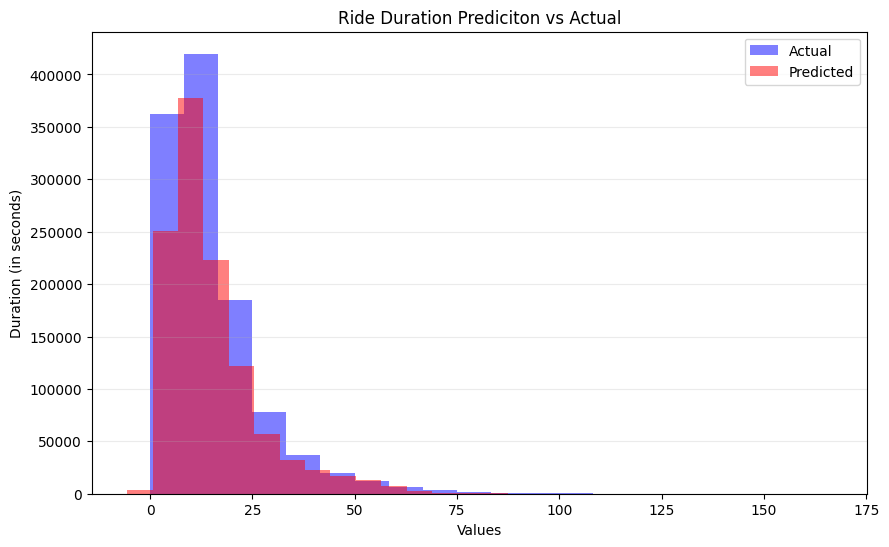

In [22]:
# Plot histograms for y_test and y_pred (overlaid)
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, alpha=0.5, color='blue', label='Actual')
plt.hist(y_pred, bins=20, alpha=0.5, color='red', label='Predicted')

# Add labels, title, and legend
plt.xlabel('Values')
plt.ylabel('Duration (in seconds)')
plt.title('Ride Duration Prediciton vs Actual')
plt.legend()

plt.grid(axis='y', alpha=0.25)  # Add a subtle grid for readability
plt.show()

## Save Model

In [23]:
joblib.dump(pipeline, 'model/boosting_pipeline.pkl')

['model/boosting_pipeline.pkl']

In [24]:
# Test loading the model
loaded_model = joblib.load('model/boosting_pipeline.pkl')

In [25]:
loaded_model.predict(X_train.loc[[0], :])

array([15.96016185])